In [15]:
import os
import sys
import time
import calendar
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from matplotlib.cm import coolwarm
from datetime import datetime, timedelta
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

### --- CHANGE 1 : 新增多电芯参数库 -------------------------------
# 典型参数来源：Panasonic NCR18650(NMC/NCA)、CATL/LFP 白皮书等公开数据
# 数值只取“大类代表”，你可以再精细化
cell_library = {
    # 三元（NMC/NCA） ≈ 动力车用圆柱
    'NMC': dict(
        H=24*60,                 # min
        C_max=1.0,                # 1/h，1C
        tilde_Q_1=3.0,           # Ah
        tilde_V=3.6,             # V
        N=0.5,                   # ×1e6
        cons_z=0.60,
        cons_alpha=29.0,
        cons_beta=74.0,
        cons_delta=1/60,
        cons_eta=155.0,
        cons_E_a=35000,          # J/mol
        cons_R_g=8.314,
        cons_T=273.15+25,
        cons_omega=np.exp(-35000/(8.314*(273.15+25)))
    ),
    # 磷酸铁锂（LFP）
    'LFP': dict(
        H=24*60,
        C_max=1.0,               # LFP 通常允许 1C
        tilde_Q_1=3.2,
        tilde_V=3.2,
        N=0.5,
        cons_z=0.55,
        cons_alpha=25.0,
        cons_beta=70.0,
        cons_delta=1/60,
        cons_eta=120.0,
        cons_E_a=30000,
        cons_R_g=8.314,
        cons_T=273.15+25,
        cons_omega=np.exp(-30000/(8.314*(273.15+25)))
    )
}
# 选一个“当前正在模拟的”电芯，保持与后续旧代码兼容
cell_constants = cell_library['NMC']
### --- CHANGE 1 END ---------------------------------------------

### --- CHANGE 2 : 新增工具函数 -----------------------------------
def choose_cell(chemistry: str):
    """返回一个深拷贝，避免在循环里相互污染"""
    import copy
    if chemistry not in cell_library:
        raise ValueError(f'未知电芯类型: {chemistry}')
    return copy.deepcopy(cell_library[chemistry])
### --- CHANGE 2 END ----------------------------------------------


def aging(tilde_b_t, tilde_q_t, tilde_Q_t, ah_t, Sigma_rho_t, cell_constants, approx=False):
    mu_t = cell_constants['cons_beta'] * cell_constants['cons_omega'] * cell_constants['cons_z'] * np.power(ah_t, cell_constants['cons_z'] - 1)
    nu_t = 0 if tilde_Q_t == 0 else cell_constants['cons_alpha'] / (cell_constants['cons_beta'] * tilde_Q_t)
    lambda_t = 0 if tilde_Q_t == 0 else cell_constants['cons_eta'] / (cell_constants['cons_R_g'] * cell_constants['cons_T'] * tilde_Q_t)
    if approx == False:
        rho_t = mu_t * abs(tilde_b_t) * (1 + (nu_t * tilde_q_t)) * np.exp(lambda_t * abs(tilde_b_t))
    else:
        rho_t = mu_t * abs(tilde_b_t) * (1 + (nu_t * (tilde_Q_t/2)))
    Sigma_rho_t = Sigma_rho_t + rho_t
    l_t = Sigma_rho_t * cell_constants['cons_delta']
    tilde_Q_t = cell_constants['tilde_Q_1'] * (1 - l_t)
    return l_t, tilde_Q_t, mu_t, nu_t, Sigma_rho_t

# 原: def bang_bang_simulator(cell_constants, approx=False):
def bang_bang_simulator(cell_constants: dict, approx=False):
    E = int(20 * 365 * cell_constants['H'] + 6 * cell_constants['H'])
    # Pre-allocate cell-level variables
    tilde_b = np.zeros((E,))
    tilde_q = np.zeros((E,))
    tilde_Q = np.zeros((E,))
    l = np.zeros((E,))
    ah = np.zeros((E,))
    mu_one_plus_nu_q = np.zeros((E,))
    Sigma_rho = np.zeros((E,))
    # Initilize variables
    cycle_state = 'charge'
    tilde_b_t = 0.0
    tilde_q_t = 0.0
    tilde_q_t_1 = 0.0
    tilde_Q_t = cell_constants['tilde_Q_1']
    Sigma_rho_t = 0.0
    ah_t = 2.5
    for e in range(E):
        if tilde_Q_t <= 0.90 * cell_constants['tilde_Q_1']:
            break
        tilde_b_t = -cell_constants['C_max'] * tilde_Q_t if cycle_state == 'charge' else cell_constants['C_max'] * tilde_Q_t
        tilde_q_t_1 = tilde_q_t
        tilde_q_t = np.clip(tilde_q_t_1 - tilde_b_t * cell_constants['cons_delta'], 0, tilde_Q_t)
        tilde_b_t = (tilde_q_t - tilde_q_t_1) / cell_constants['cons_delta']
        ah_t = ah_t + (abs(tilde_b_t)*cell_constants['cons_delta'])
        l_t, tilde_Q_t, mu_t, nu_t, Sigma_rho_t = aging(tilde_b_t, tilde_q_t, tilde_Q_t, ah_t, Sigma_rho_t, cell_constants, approx)
        mu_one_plus_nu_q_t = mu_t * (1 + (nu_t * 0.5*tilde_Q_t))
 
        # Update variables
        tilde_b[e] = tilde_b_t
        tilde_q[e] = tilde_q_t
        tilde_Q[e] = tilde_Q_t
        l[e] = l_t
        ah[e] = ah_t
        Sigma_rho[e] = Sigma_rho_t
        mu_one_plus_nu_q[e] = mu_one_plus_nu_q_t
        
        # Update cycle state
        if cycle_state == 'charge' and tilde_q_t >= 0.99 * tilde_Q_t:
            cycle_state = 'discharge'
        elif cycle_state == 'discharge' and tilde_q_t <= 0.01 * tilde_Q_t:
            cycle_state = 'charge'

    E_sim = e
    # Trim cell-level variables
    tilde_b = tilde_b[:E_sim]
    tilde_q = tilde_q[:E_sim]
    tilde_Q = tilde_Q[:E_sim]
    l = l[:E_sim]
    ah = ah[:E_sim]
    mu_one_plus_nu_q = mu_one_plus_nu_q[:E_sim]
    Sigma_rho = Sigma_rho[:E_sim]
    cell_variables = {'tilde_b': tilde_b, 
                      'tilde_q': tilde_q, 
                      'tilde_Q': tilde_Q, 
                      'l': l, 
                      'ah': ah, 
                      'mu_one_plus_nu_q': mu_one_plus_nu_q, 
                      'Sigma_rho': Sigma_rho}
    lifetime_in_years = E_sim / (365*cell_constants['H'])
    num_cycles = np.sum(np.diff(np.sign(tilde_b)) != 0)//2
    ah_at_the_end = ah[-1]
    return cell_variables, E_sim, lifetime_in_years, num_cycles, ah_at_the_end

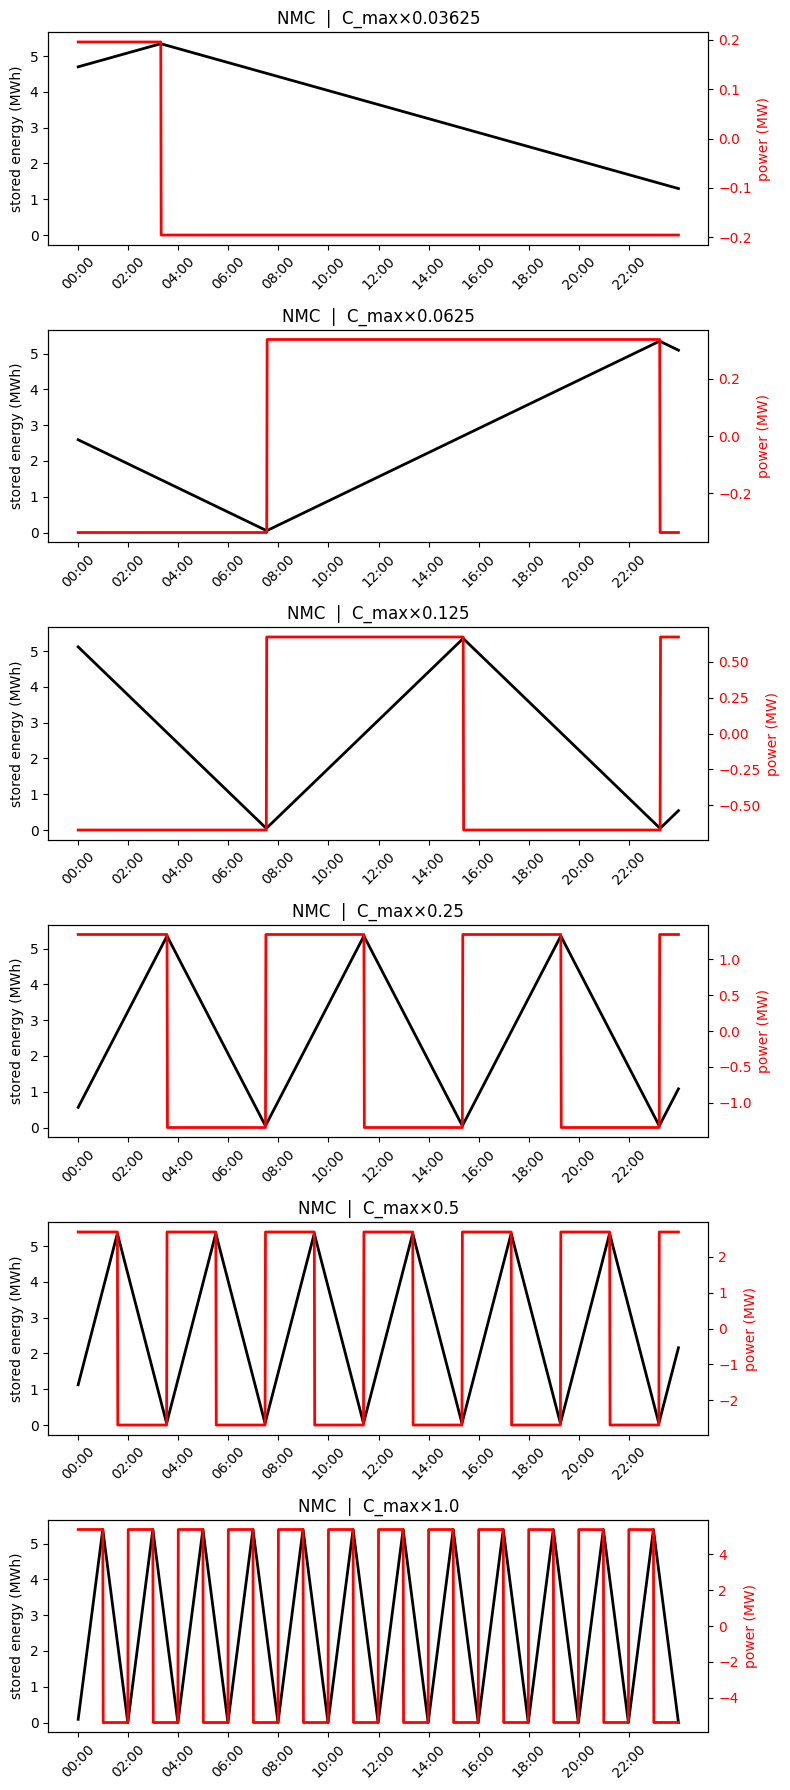

C:\Users\msz\AppData\Local\Temp\ipykernel_70088\4118722911.py:65: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\msz\anaconda3\envs\battery\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


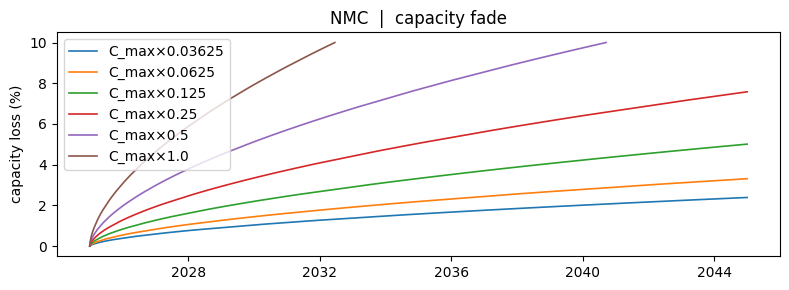

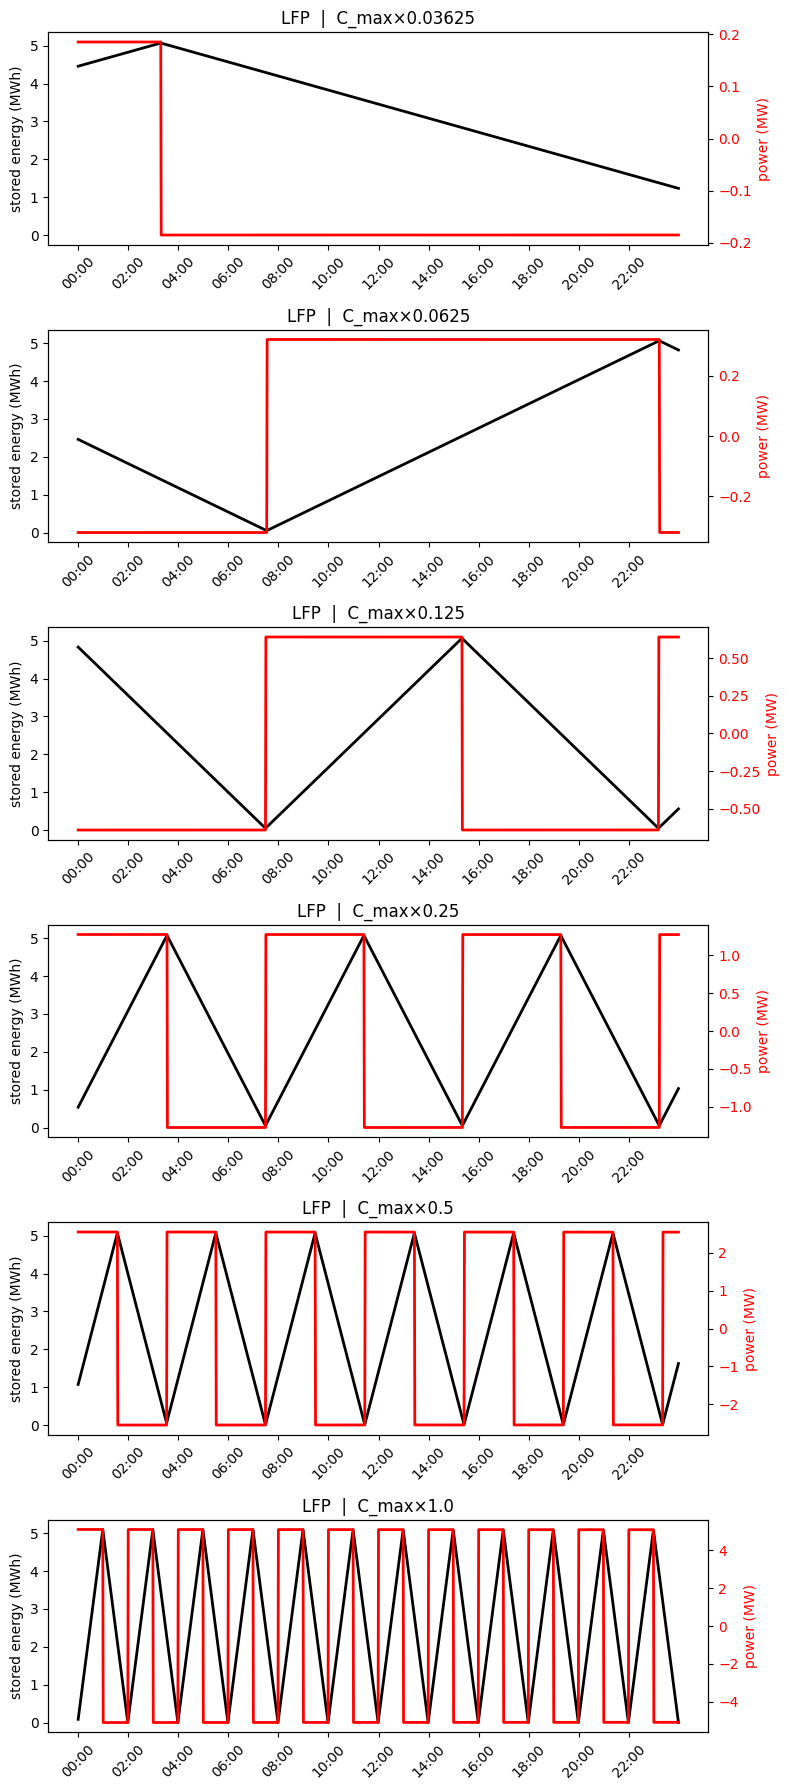

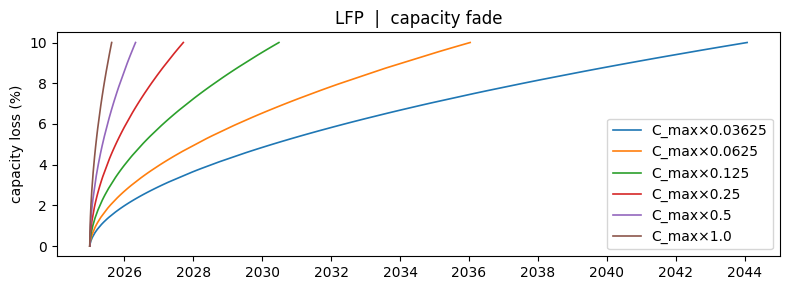


===== SUMMARY =====


,Chem,C_rate_mult,Lifetime_yr,Cycles,Ah_Throughput
0,NMC,0.03625,20.016436,3240,18786
1,NMC,0.06250,20.016436,5585,32198
2,NMC,0.12500,20.016436,11158,63690
3,NMC,0.25000,20.016436,22270,125235
4,NMC,0.50000,15.721718,34832,193543
5,NMC,1.00000,7.462137,32684,183726
6,LFP,0.03625,19.079644,3089,18132
7,LFP,0.06250,11.040734,3080,18090
8,LFP,0.12500,5.490323,3060,17992
9,LFP,0.25000,2.715379,3021,17796


In [18]:
# === MAIN EXPERIMENT LOOP =====================================================
# 如果只想测试部分电芯，改动这个列表即可
chem_list = list(cell_library.keys())          # e.g. ['NMC', 'LFP']
rate_mults = [0.03625,0.0625,0.125,0.25, 0.5, 1.0]                        # 0.5 × C_max 和 1.0 × C_max

summary_rows = []
for chem in chem_list:
    const_base = choose_cell(chem)             # 深拷贝，互不干扰
    H = const_base['H']
    
    # 存放两种倍率下的曲线，便于绘图
    daily_profiles = {}
    loss_profiles  = {}
    
    for mult in rate_mults:
        const = choose_cell(chem)
        const['C_max'] = const['C_max'] * mult
        
        # ‑‑ 精确模型（approx=False） ------------------------------------------------
        cell_vars, E_sim, life, cycles, ah_end = bang_bang_simulator(const, approx=False)
        # 只留一天做“充放电曲线”展示
        q = cell_vars['tilde_q'] * const['N'] * const['tilde_V']
        b = cell_vars['tilde_b'] * const['N'] * const['tilde_V']
        daily_profiles[mult] = (q, b)
        
        # “容量衰减曲线” 全程
        loss_profiles[mult] = cell_vars['l']
        
        summary_rows.append(
            dict(Chem=chem, C_rate_mult=mult, Lifetime_yr=life,
                 Cycles=cycles, Ah_Throughput=int(ah_end))
        )
    
    # -------------------------- 画图（每个 chem 单独成图） -------------------------
    # 1) 一天内充放电曲线
    times_day = pd.date_range('2000-01-01 00:00', periods=2*H, freq='1min')   # 保留生成 2H 记录
    fig, axes = plt.subplots(len(rate_mults), 1, figsize=(8, 3*len(rate_mults)), sharey='col')
    if len(rate_mults) == 1: axes=[axes]
    for idx, mult in enumerate(rate_mults):
        q, b = daily_profiles[mult]
        ax = axes[idx]
        ax.plot(times_day[H:2*H], q[H:2*H], color='k', lw=2, label='SoC·MWh')
        ax.set_ylabel('stored energy (MWh)')
        ax.set_xticks(pd.date_range(times_day.min(), times_day.max(), freq='2h'))
        ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
        ax.tick_params(axis='x', rotation=45)
        ax_t = ax.twinx()
        ax_t.plot(times_day[H:2*H], b[H:2*H], color='red', lw=2, label='power·MW')
        ax_t.set_ylabel('power (MW)', color='red')
        ax_t.tick_params(axis='y', labelcolor='red')
        ax.set_title(f'{chem}  |  C_max×{mult}')
    plt.tight_layout()
    plt.show()
    
    # 2) 全寿命容量衰减
    fig, ax = plt.subplots(figsize=(8,3))
    for mult in rate_mults:
        l = loss_profiles[mult]
        t = pd.date_range('2025-01-01', periods=len(l), freq='1min')
        ax.plot(t, l*100, lw=1.2, label=f'C_max×{mult}')
    ax.set_ylabel('capacity loss (%)')
    ax.legend()
    ax.set_title(f'{chem}  |  capacity fade')
    ax.xaxis.set_major_formatter(DateFormatter('%Y'))
    plt.tight_layout()
    plt.show()

# ====================== 打印总结表 ============================================
summary_df = pd.DataFrame(summary_rows)
print('\n===== SUMMARY =====')
display(summary_df)


In [2]:
# cell_constants['C_max'] = 0.333/2
# cell_variables_actual_1, E_sim_actual_1, lifetime_actual_1, num_cycles_actual_1, ah_at_the_end_actual_1 = bang_bang_simulator(cell_constants, False)
# cell_variables_approx_1, E_sim_approx_1, lifetime_approx_1, num_cycles_approx_1, ah_at_the_end_approx_1 = bang_bang_simulator(cell_constants, True)
# cell_constants['C_max'] = 0.333
# cell_variables_actual_2, E_sim_actual_2, lifetime_actual_2, num_cycles_actual_2, ah_at_the_end_actual_2 = bang_bang_simulator(cell_constants, False)
# cell_variables_approx_2, E_sim_approx_2, lifetime_approx_2, num_cycles_approx_2, ah_at_the_end_approx_2 = bang_bang_simulator(cell_constants, True)

# # Extract variables
# q_actual_1 = cell_variables_actual_1['tilde_q']*cell_constants['N']*cell_constants['tilde_V']
# q_approx_1 = cell_variables_approx_1['tilde_q']*cell_constants['N']*cell_constants['tilde_V']
# q_actual_2 = cell_variables_actual_2['tilde_q']*cell_constants['N']*cell_constants['tilde_V']
# q_approx_2 = cell_variables_approx_2['tilde_q']*cell_constants['N']*cell_constants['tilde_V']

# b_actual_1 = cell_variables_actual_1['tilde_b']*cell_constants['N']*cell_constants['tilde_V']
# b_approx_1 = cell_variables_approx_1['tilde_b']*cell_constants['N']*cell_constants['tilde_V']
# b_actual_2 = cell_variables_actual_2['tilde_b']*cell_constants['N']*cell_constants['tilde_V']
# b_approx_2 = cell_variables_approx_2['tilde_b']*cell_constants['N']*cell_constants['tilde_V']

# l_actual_1 = cell_variables_actual_1['l']
# l_approx_1 = cell_variables_approx_1['l']
# l_actual_2 = cell_variables_actual_2['l']
# l_approx_2 = cell_variables_approx_2['l']

# ah_actual_1 = cell_variables_actual_1['ah']
# ah_approx_1 = cell_variables_approx_1['ah']
# ah_actual_2 = cell_variables_actual_2['ah']
# ah_approx_2 = cell_variables_approx_2['ah']

In [3]:
# print(f'lifetime_actual_1: {lifetime_actual_1:.3f} years, num_cycles_actual_1: {num_cycles_actual_1}, ah at end: {ah_at_the_end_actual_1:.1f}')
# print(f'lifetime_approx_1: {lifetime_approx_1:.3f} years, num_cycles_approx_1: {num_cycles_approx_1}, ah at end: {ah_at_the_end_approx_1:.1f}')
# print(f'lifetime_actual_2: {lifetime_actual_2:.3f} years, num_cycles_actual_2: {num_cycles_actual_2}, ah at end: {ah_at_the_end_actual_2:.1f}')
# print(f'lifetime_approx_2: {lifetime_approx_2:.3f} years, num_cycles_approx_2: {num_cycles_approx_2}, ah at end: {ah_at_the_end_approx_2:.1f}')

lifetime_actual_1: 5.599 years, num_cycles_actual_1: 4154, ah at end: 19131.7
lifetime_approx_1: 5.695 years, num_cycles_approx_1: 4225, ah at end: 19459.2
lifetime_actual_2: 2.752 years, num_cycles_actual_2: 4073, ah at end: 18809.6
lifetime_approx_2: 2.847 years, num_cycles_approx_2: 4213, ah at end: 19459.3


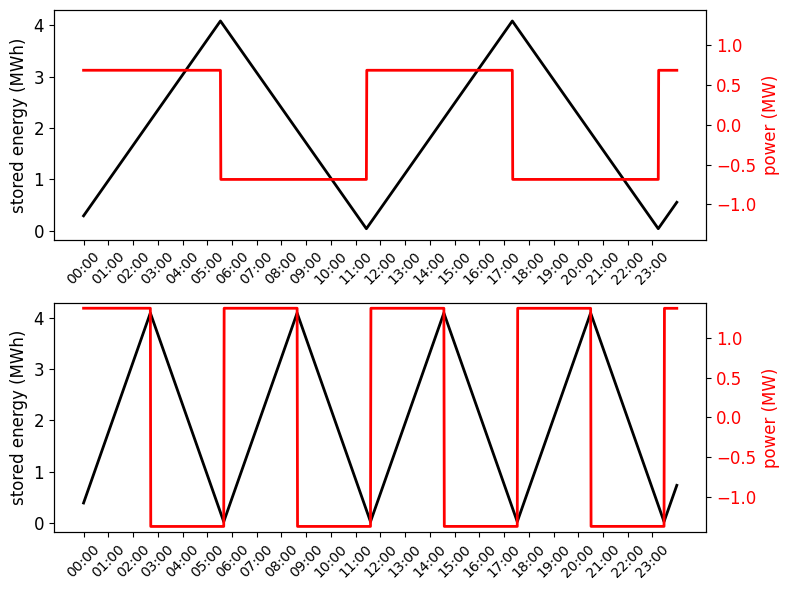

In [4]:
# output_dir = "./figures"
# os.makedirs(output_dir, exist_ok=True)
# file_name = 'charging_profiles.pdf'
# file_path = os.path.join(output_dir, file_name)
# H = cell_constants['H']
# times = pd.date_range(start=f'{2000}-01-01 00:00', end=f'{2000}-01-01 23:59', freq='1min')
# fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharey='col')

# axes[0].plot(times, q_actual_1[H:2*H], label=r'$q_t$', color = 'black', linewidth = 2)
# axes[0].set_ylabel('stored energy (MWh)', fontsize = 12)
# axes[0].tick_params(axis = 'y', which = 'major', labelsize = 12, labelcolor='black')
# axes[0].grid(False)
# axes[0].set_xticks(pd.date_range(start=times.min(), end=times.max(), freq='h'))
# axes[0].xaxis.set_major_formatter(DateFormatter('%H:%M'))
# axes[0].tick_params(axis='x', rotation=45)
# ax2 = axes[0].twinx()
# ax2.plot(times, b_actual_1[H:2*H], label=r'$b_t$', color='red', linewidth=2)
# ax2.set_ylabel('power (MW)', color='red', fontsize=12)
# ax2.set_ylim(-4.125*0.35, 4.125*0.35)
# ax2.tick_params(axis='y', labelcolor='red', labelsize=12)

# axes[1].plot(times, q_actual_2[H:2*H], label=r'$q_t$', color = 'black', linewidth = 2)
# axes[1].set_ylabel('stored energy (MWh)', fontsize = 12)
# axes[1].tick_params(axis = 'y', which = 'major', labelsize = 12, labelcolor='black')
# axes[1].grid(False)
# axes[1].set_xticks(pd.date_range(start=times.min(), end=times.max(), freq='h'))
# axes[1].xaxis.set_major_formatter(DateFormatter('%H:%M'))
# axes[1].tick_params(axis='x', rotation=45)
# ax4 = axes[1].twinx()
# ax4.plot(times, b_actual_2[H:2*H], label=r'$b_t$', color='red', linewidth=2)
# ax4.set_ylabel('power (MW)', color='red', fontsize=12)
# ax4.set_ylim(-4.125*0.35, 4.125*0.35)
# ax4.tick_params(axis='y', labelcolor='red', labelsize=12)
# plt.tight_layout()
# #plt.savefig(file_path, bbox_inches='tight')
# plt.show()

In [8]:
# times_actual_1 = pd.date_range(start=f'{2025}-01-01 00:00', periods = E_sim_actual_1, freq='1min')
# times_approx_1 = pd.date_range(start=f'{2025}-01-01 00:00', periods = E_sim_approx_1, freq='1min')
# times_actual_2 = pd.date_range(start=f'{2025}-01-01 00:00', periods = E_sim_actual_2, freq='1min')
# times_approx_2 = pd.date_range(start=f'{2025}-01-01 00:00', periods = E_sim_approx_2, freq='1min')

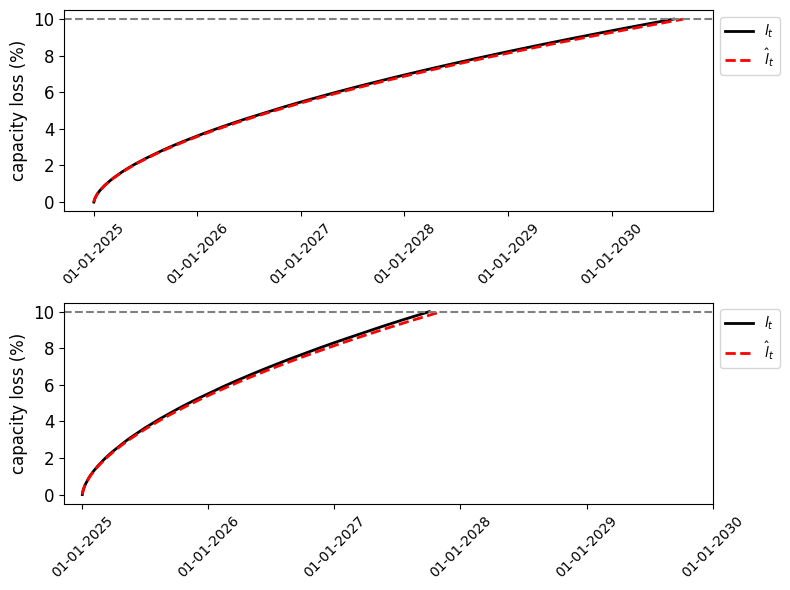

In [10]:
# output_dir = "./figures"
# os.makedirs(output_dir, exist_ok=True)
# file_name = 'loss_profiles.pdf'
# file_path = os.path.join(output_dir, file_name)

# fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharey='col')

# axes[0].plot(times_actual_1, l_actual_1*100, label=r'$l_t$', color = 'black', linewidth = 2, linestyle = 'solid')
# axes[0].plot(times_approx_1, l_approx_1*100, label=r'$\hat{l}_t$', color = 'red', linewidth = 2, linestyle = 'dashed')
# axes[0].axhline(y=np.max(l_actual_1*100), color='gray', linestyle='--', label='')
# axes[0].set_ylabel('capacity loss (%)', fontsize=12)
# axes[0].tick_params(axis='y', which='major', labelsize=12, labelcolor='black')
# axes[0].grid(False)
# axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
# axes[0].set_xticks(pd.date_range(start=times_approx_1.min(), end=times_approx_1.max(), freq='YS'))
# axes[0].xaxis.set_major_formatter(DateFormatter('%m-%d-%Y'))
# axes[0].tick_params(axis='x', rotation=45)

# axes[1].plot(times_actual_2, l_actual_2*100, label=r'$l_t$', color='black', linewidth=2, linestyle='solid')
# axes[1].plot(times_approx_2, l_approx_2*100, label=r'$\hat{l}_t$', color='red', linewidth=2, linestyle='dashed')
# axes[1].axhline(y=np.max(l_actual_2*100), color='gray', linestyle='--', label='')
# axes[1].set_ylabel('capacity loss (%)', fontsize=12)
# axes[1].tick_params(axis='y', which='major', labelsize=12, labelcolor='black')
# axes[1].grid(False)
# axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
# axes[1].set_xticks(pd.date_range(start=times_approx_1.min(), end=times_approx_1.max(), freq='YS'))
# axes[1].xaxis.set_major_formatter(DateFormatter('%m-%d-%Y'))
# axes[1].tick_params(axis='x', rotation=45)
# plt.tight_layout()
# #plt.savefig(file_path, bbox_inches='tight')
# plt.show()